In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cpu")
print("Using device:", device)



Using device: cpu


In [4]:
transform = transforms.ToTensor()

# Download MNIST into ./data
train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set   = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Split train into 50k train + 10k val
train_size = 50000
val_size   = len(train_full) - train_size

train_set, val_set = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=50, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=50, shuffle=False)

len(train_set), len(val_set), len(test_set)


100.0%
100.0%
100.0%
100.0%


(50000, 10000, 10000)

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Two conv layers: 1→6 and 6→10 channels, 3x3 kernels, stride 1
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3, stride=1)

        self.relu = nn.ReLU()

        # 28x28 → conv1 (3x3) → 26x26 → conv2 (3x3) → 24x24
        self.fc = nn.Linear(10 * 24 * 24, 10)

        # Softmax layer with 10 neurons for output (use log-softmax for NLLLoss)
        self.softmax = nn.LogSoftmax(dim=1)

        # Xavier initialization (uniform)
        for layer in [self.conv1, self.conv2, self.fc]:
            nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return self.softmax(x)

model = CNNModel().to(device)
model


CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (fc): Linear(in_features=5760, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [6]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * x.size(0)
            correct += (preds.argmax(1) == y).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


In [8]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# LR scheduler: reduce lr by 10% every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

EPOCHS = 100
patience = 10  # early stopping patience

best_val_loss = float('inf')
best_model_state = None
no_improve_epochs = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    scheduler.step()

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1:3d} | "
        f"Train Loss: {tr_loss:.4f}, Val Loss: {val_loss:.4f}, "
        f"Train Acc: {tr_acc:.4f}, Val Acc: {val_acc:.4f}"
    )

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered!")
            break

# load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)


Epoch   1 | Train Loss: 0.1902, Val Loss: 0.0895, Train Acc: 0.9426, Val Acc: 0.9733
Epoch   2 | Train Loss: 0.0719, Val Loss: 0.0802, Train Acc: 0.9779, Val Acc: 0.9750
Epoch   3 | Train Loss: 0.0485, Val Loss: 0.0932, Train Acc: 0.9853, Val Acc: 0.9739
Epoch   4 | Train Loss: 0.0342, Val Loss: 0.0772, Train Acc: 0.9891, Val Acc: 0.9775
Epoch   5 | Train Loss: 0.0271, Val Loss: 0.0909, Train Acc: 0.9914, Val Acc: 0.9785
Epoch   6 | Train Loss: 0.0205, Val Loss: 0.1040, Train Acc: 0.9932, Val Acc: 0.9776
Epoch   7 | Train Loss: 0.0189, Val Loss: 0.1052, Train Acc: 0.9936, Val Acc: 0.9769
Epoch   8 | Train Loss: 0.0174, Val Loss: 0.1394, Train Acc: 0.9940, Val Acc: 0.9762
Epoch   9 | Train Loss: 0.0130, Val Loss: 0.1114, Train Acc: 0.9955, Val Acc: 0.9789
Epoch  10 | Train Loss: 0.0085, Val Loss: 0.1300, Train Acc: 0.9971, Val Acc: 0.9781
Epoch  11 | Train Loss: 0.0102, Val Loss: 0.1290, Train Acc: 0.9965, Val Acc: 0.9792
Epoch  12 | Train Loss: 0.0064, Val Loss: 0.1140, Train Acc: 0.99

Test Accuracy: 98.32%


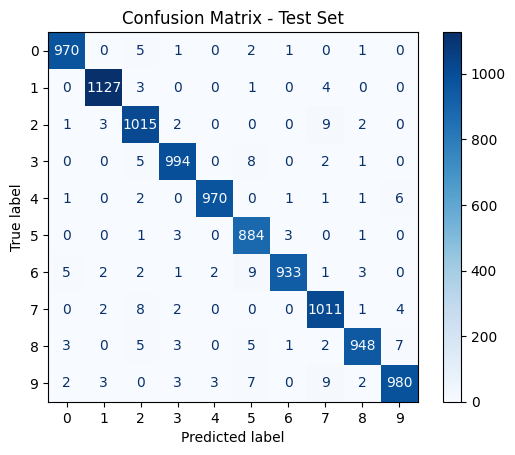

In [9]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        preds = model(x).argmax(1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Test Accuracy: {test_acc * 100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()


The test accuracy is approximately 98%. The confusion matrix shows that the model performs very well overall, with most errors occurring between visually similar digits such as 4 and 9 or 3 and 5. These confusions are common for simple CNN architectures because these digits share overlapping stroke patterns. However, the number of misclassifications is very small, indicating strong generalization.


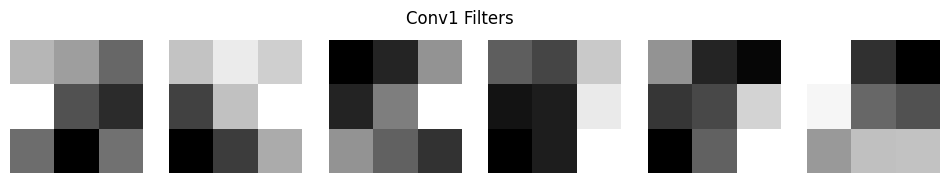

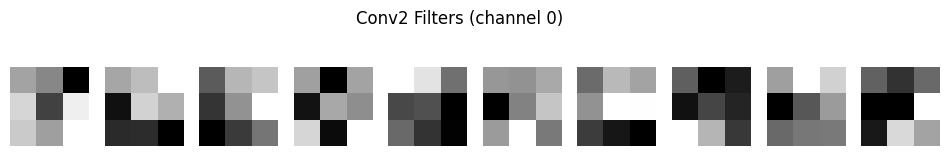

In [10]:
def show_kernels(weights, title):
    w = weights.detach().numpy()
    num_kernels = w.shape[0]

    plt.figure(figsize=(12, 2))
    for i in range(num_kernels):
        plt.subplot(1, num_kernels, i+1)
        plt.imshow(w[i, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_kernels(model.conv1.weight, "Conv1 Filters")
show_kernels(model.conv2.weight[:, :1], "Conv2 Filters (channel 0)")


The Conv1 filters mostly learn edge detectors and local stroke directions (horizontal, vertical, diagonal). These are useful for recognizing digit boundaries. The Conv2 filters appear more abstract, combining multiple edges or blob-like patterns. These higher-level features help the network capture digit-specific structures and shapes.
